# Atividade com Xcompact3d-toolbox

O objetivo deste notebook é exercitar conceitos de cálculo numérico e de CFD, como definição da resolução da malha e pós-processamento dos dados gerados por uma simulação. Esses conceitos são trabalhados a partir da ferramenta [Xcompact3d-toolbox](https://docs.fschuch.com/xcompact3d_toolbox/) que foi abordado a partir de aulas anteriores.

Nesta atividade se abordará novamente o caso do escoamento ao redor de um corpo, porém agora será explorado uma configuração diferente consistinda em um arranjo de três cilindros. Este documento é organizado em duas atividades: I) na primeira será exigida a capacidade do aluno em definir a configuração e a geométria da simulação, II) na segunda etapa será avaliada a capacidade do aluno em fazer o pós-processamento da simulação. Não modifique o código deste notebook a menos quando solicitado.

Para resolução dos exercícios propostos neste notebook, além de consultar os materiais apresentados nas aulas anteriores é recomendado fortemente consultar a documentação do [Xcompact3d-toolbox](https://docs.fschuch.com/xcompact3d_toolbox/). Também é recomendado verificar a documentação das bibliotecas [xarray](https://docs.xarray.dev/en/stable/), [numpy](https://numpy.org/), [matplotlib](https://matplotlib.org/) e [hvplot](https://hvplot.holoviz.org/en/docs/latest/index.html).

# Instalação

O ambiente do LAD deve conter todas as dependências necessárias, porém as linhas abaixo podem ser usadas para instalar as bibliotecas exigidas para esse notebook usando [pip](https://pip.pypa.io/en/stable/). Se mesmo assim se seu ambiente de trabalho ainda não contiver todas as bibliotecas necessárias, utilize [pip](https://pip.pypa.io/en/stable/) ou qualquer outro gerenciador de pacotes para instalar as bibliotecas python necessárias.

In [ ]:
!pip install xcompact3d_toolbox

In [ ]:
!pip install hvplot

In [ ]:
!pip install datashader

# Importando bibliotecas

Execute o código abaixo para importar as bibliotecas necessárias para execução deste notebook.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import xarray as xr
import hvplot.xarray
import xcompact3d_toolbox as x3d

import warnings
warnings.filterwarnings('ignore')

# Atividade 1: definindo a configuração do experimento

Neste notebook se abordará o caso de um escoamento ao redor de um corpo, porém dessa vez se abordará um arranjo composto por três cilindro, como na imagem abaixo:

<img src="img/threeCylinder.png">

Na primeira etapa deste notebook é trabalharado como se definir os parâmetros e a geométria da simulação.

## a. Inicializando os parâmetros da simulação


Inicialize os parâmetros para a configuração de um escoamento com três cilindros para um número de Reynolds 300. O domínio espacial é um paralelepípedo de dimensões Lx * Ly * Lz tridimensional com os seguintes comprimentos:

- Lx = 15
- Ly = 10
- Lz = 3

Para isso utilize a classe `ParametersGui`, que permite definir os parâmetros da simulação utilizando uma interface interativa com [ipywidgets](https://ipywidgets.readthedocs.io/en/latest/). Execute a célula abaixo para gerar uma instância da classe `ParametersGui`.

In [ ]:
prm = x3d.ParametersGui(
    filename="input.i3d",
    itype=12,
    p_row=0,
    p_col=0,
    xlx = 15,
    yly = 10,
    zlz = 3,
    nclx1=0,
    nclxn=0,
    ncly1=0,
    nclyn=0,
    nclz1=1,
    nclzn=1,
    iin=1,
    iibm=2,
    nu0nu=4.0,
    cnu=0.44,
    irestart=0,
    icheckpoint=45000,
    ioutput=200,
    iprocessing=50,
    jles=4,
)

A configuração deste notebook possui as seguintes condições de contorno:

- Condição de entrada em x = 0 e saída em x = Lx
- Deslizamento livre em y = 0 e y = Ly
- Períodico em z = 0 e z = Lz

Execute a célula de código abaixo e utilize a interface do [ipywidgets](https://ipywidgets.readthedocs.io/en/latest/) para impor essas condições ao domínio.

Lembrando que:

- nclx1 parâmetro para condição de contorno em x = 0
- nclxn parâmetro para condição de contorno em x = Lx
- ncly1 parâmetro para condição de contorno em y = 0
- nclyn parâmetro para condição de contorno em y = Ly
- nclz1 parâmetro para condição de contorno em z = 0
- nclzn parâmetro para condição de contorno em z = Lz

In [ ]:
prm("nclx1", "nclxn", "ncly1", "nclyn","nclz1", "nclzn")

Execute a célula abaixo para conferir se os parâmetros corretos foram atribuidos as condições de contorno.

In [ ]:
if(prm.nclx1 != 2):
  raise ValueError("Valor errado para a condição de contorno em x = 0, reveja a especificação")

if(prm.nclxn != 2):
  raise ValueError("Valor errado para a condição de contorno em x = L, reveja a especificação")

if(prm.ncly1 != 1):
  raise ValueError("Valor errado para a condição de contorno em y = 0, reveja a especificação")

if(prm.nclyn != 1):
  raise ValueError("Valor errado para a condição de contorno em y = L, reveja a especificação")

if(prm.nclz1 != 0):
  raise ValueError("Valor errado para a condição de contorno em z = 0, reveja a especificação")

if(prm.nclzn != 0):
  raise ValueError("Valor errado para a condição de contorno em z = L, reveja a especificação")

Com as condições de contorno definidas, execute a célula abaixo e defina o número de pontos em `nx`, `ny` e `nz`. Lembrando que o domínio deve possuir as seguintes dimensões:

- Lx = 15
- Ly = 10
- Lz = 3
- dx = 0.058
- dy = 0.078
- dz = 0.094

<u>Dica</u>: lembrando que podemos calcular o número de pontos em x, y e z como `nx=Lx*dx`, `ny=Ly*dy` e `nz=Lz*dz`.

In [ ]:
prm("nx", "ny","nz")

Execute a célula abaixo para conferir se foram atribuidos os valores corretos para `nx`, `ny` e `nz`.

In [ ]:
if(prm.nx != 257):
  raise ValueError("Valor errado para o número de pontos em x, reveja a especificação")

if(prm.ny != 129):
  raise ValueError("Valor errado para o número de pontos em y, reveja a especificação")

if(prm.nz != 32):
  raise ValueError("Valor errado para o número de pontos em y, reveja a especificação")

Podemos visualizar na tela os parâmetros da simulação no formato do arquivo de entrada do Xcompact3d.

In [ ]:
print(prm)

! -*- mode: f90 -*-

!===================
&BasicParam
!===================

       C_filter = 0.49            ! 
           beta = 1.0             ! Refinement parameter
             dt = 0.001           ! Time step
          gravx = 0.0             ! Gravity unitary vector in x-direction
          gravy = 0.0             ! Gravity unitary vector in y-direction
          gravz = 0.0             ! Gravity unitary vector in z-direction
        ifilter = 0               ! 
         ifirst = 0               ! The number for the first iteration
           iibm = 2               ! Flag for immersed boundary method (0: No, 1: Yes)
            iin = 1               ! Defines perturbation at initial condition
          ilast = 0               ! The number for the last iteration
        ilesmod = 0               ! Enables Large-Eddy methodologies (0: No, 1: Yes)
           ilmn = .false.         ! 
   inflow_noise = 0.0             ! Turbulence intensity (1=100%) !! Inflow condition
     init_no

`mpirun`

## b. Definindo geométria

Agora com os parâmetros já definidos gere a geométria da configuração. Gere um arranjo com três cilindros com raio `r = 1.0` com o centro posicionado em `C1=(5,2.5)`, `C2=(5,7.5)` e `C1=(7.5,5)`. Na imagem abaixo pode se ver como deve ficar a geometria do problema:

<img src = "img/threeCylinder.png">

Com a linha de código `epsi = x3d.init_epsi(prm)` gera-se um dicionário com as quatro matrizes $\epsilon$ em um dicionário. Para adicionar um cilindro no domínio pode-se utilizar o método `geo.cylinder(x,y)`, para que o objeto seja adicionado em todas as matrizes pode-se usar um loop `for`. Assim para adicionar um único cilindro centrado em (7.5,5) ao domínio pode-se utilizar o código abaixo:

```
for key in epsi:
    epsi[key] = epsi[key].geo.cylinder(7.5,5)
```

Esse código gera a seguinte geométria:

<img src = "img/cylinder.png">

Na célula a baixo escreva o código para o gerar o arranjo com três cilindros.

<font color="red"><u>IMPORTANTE</u></font>: escreva o seu código unicamente entre as linhas `# Seu código vai aqui` e `# Fim`. Não modifique o resto da célula.

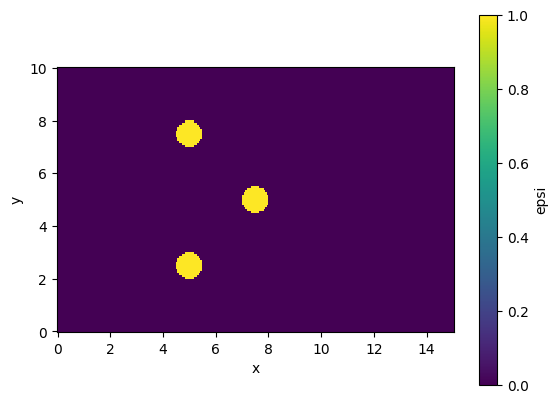

In [ ]:
epsi = x3d.init_epsi(prm)

for key in epsi:
    # Seu código vai aqui
    epsi[key] = epsi[key].geo.cylinder(x=5, y=prm.yly / 4.0)
    epsi[key] = epsi[key].geo.cylinder(x=5, y=3*prm.yly / 4.0)
    epsi[key] = epsi[key].geo.cylinder(x=7.5, y=prm.yly / 2.0)
    # Fim

g = epsi["epsi"].sel(z=0, method="nearest").plot(x="x")
g.axes.set_aspect("equal")
g.axes.set_title("");

Com a malha definida pode-se salva-lá no disco para posteriormente executar a simulação utilizando o solver do `Xcompact3d`. Isso pode ser feito entrando com o seguinte comando no terminal:

```bash
mpirun -n [number of cores] ./xcompact3d |tee log.out
```

Não será exigido executar a simulação, porém para as próximas atividades será utilizado dados provenientes de uma simulação com essa configuração.

# Atividade 2: pós-processamento

Nesta atividade o objetivo é pós-processar os dados gerados por uma simulação. Como exercício continuaremos com o arranjo com três cilindros, porém utilizaremos apenas um plano bidimensional em `xy` devido ao tamnho da simulação. Neste notebook será explorada duas grandezas a energia cinética e a vorticidade do escoamento.

## Carregando dados

Na célula abaixo é carregado na memória os dados do plano `xy` no formato de um objeto xarray.

In [ ]:
# Abrindo o banco de dados
dataset = xr.open_dataset("cylinder_plane_xy.nc")
dataset

<xarray.Dataset> Size: 120MB
Dimensions:  (x: 257, y: 129, t: 226)
Coordinates:
  * x        (x) float64 2kB 0.0 0.05859 0.1172 0.1758 ... 14.88 14.94 15.0
  * y        (y) float64 1kB 0.0 0.07812 0.1562 0.2344 ... 9.844 9.922 10.0
  * t        (t) float64 2kB 0.0 0.5 1.0 1.5 2.0 ... 111.0 111.5 112.0 112.5
Data variables:
    ux       (x, y, t) float64 60MB ...
    uy       (x, y, t) float64 60MB ...
    epsi     (x, y) float64 265kB ...

## a. Energia cinética

Como primeira atividade de pós-processamento, pede-se que seja feito o cáluclo da energia cinética do escoamento, definido pela equação abaixo:

$$
k = \int_V \dfrac{u_iu_i}{2} dV
$$

Complete a célula abaixa com o cálculo da energia cinética, sendo que o resultado deve armazenado no objeto xarray, isso pode ser feito atribuindo uma nova variável ao banco de dados com o seguinte comando

```
dataset["kinetic_energy"] = resultado_do_calculo_de_k
```

<font color="red"><u>IMPORTANTE</u></font>: para correção do resultado e funcionamento das células seguintes é impresendível que o resultado do cálculo seja armazenado no objeto `dataset` exatamente como na linha de código anterior. Você tem a liberdade total em como fazer esse cálculo, porém com xarray é possível em uma única linha de código realizar esse cálculo.

<u>Dica 1</u>: xarray é construído sobre [numpy](https://numpy.org/) arrays perminto operações aritméticas entre `dataset` como se fossem arrays numpy. Assim para aplicar uma operação aritmética entre dois `dataset` pode-se usar a linha a baixo:

```
A*B
```

Onde `A` e `B` são dois xarray diferentes, também pode-se aplicar operações com constantes sobre o `dataset`

```
0.5*A
```

Para aplicar uma exponencial sobre o `dataset` pode-se usar um código similar a

```
A**2
```

<u>Dica 2</u>: para aplicar uma operação de redução sobre o `dataset` pode-se usar o  método `sum`, assim para somar todos os elementos para o eixo `x` pode-se usar o código:

```
dataset.sum("x")
```

<u>Dica 3</u>: para aplicar uma função sobre o `dataset` pode-se user qualquer função já compatível com um numpy array. Como exemplo, veja a baixo o código com a aplicação para a integral de Simpson da biblioteca [scipy](https://scipy.org/).

```
scipy.integrate.simps(dataset, dataset.coords['x'])
```

In [ ]:
# Cálculo da energia cinética
dataset["kinetic_energy"] = ((dataset.ux**2+dataset.uy**2).x3d.simpson("x", "y")) * 0.5

Execute a célula a baixo para verificar a precisão do seu cálculo.

In [ ]:
if not np.allclose(dataset.kinetic_energy, ((dataset.ux**2+dataset.uy**2).x3d.simpson("x", "y")) * 0.5, atol = 1e-4):
  raise ValueError("Valor errado para a energia cinética, reveja seu código")

Podemos visualizar o resultado do pós-processamento com o método `plot`. Execute a célula a baixo e observe o gráfico.

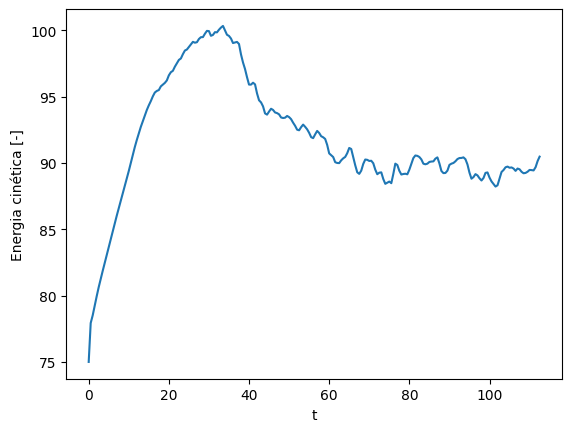

In [ ]:
dataset["kinetic_energy"].attrs = {"name": "k", "long_name": "Energia cinética", "units": "-"}
dataset["kinetic_energy"].plot();

## b. Cálculo da vorticidade

Como próxima atividade pede-se que seja feito o cálculo da vorticidade, dado pela equação:

$$
\omega_z = \dfrac{\partial u_y}{\partial x}  - \dfrac{\partial u_x}{\partial y}
$$

Complete a célula de código a baixa com o cálculo da vorticidade, sendo que o resultado deve armazenado no objeto xarray, isso pode ser feito atribuindo uma nova variável ao banco de dados com o seguinte comando:

```
dataset["vort"] = resultado_do_calculo_de_w
```

<font color="red"><u>IMPORTANTE</u></font>: para correção do resultado e funcionamento das células seguintes é impresendível que o resultado do cálculo seja armazenado no objeto `dataset` exatamente como na linha de código anterior. Você tem a liberdade total em como fazer esse cálculo, porém com xarray é possível em uma única linha de código realizar esse cálculo.

<u>Dica</u>: Xcompact3d-toolbox possue métodos para o cálculo numérico de derivadas. Por exemplo, para calcular a derivada $\dfrac{∂u}{∂x}$ pode-se utilizar a seguinte linha de código:

```
dataset.uy.x3d.first_derivative("x")
```

In [ ]:
dataset["vort"] = dataset.uy.x3d.first_derivative("x") - dataset.ux.x3d.first_derivative("y")

Execute a célula a baixo para verificar a precisão do seu cálculo.

In [ ]:
if not np.allclose(dataset.vort, dataset.uy.x3d.first_derivative("x") - dataset.ux.x3d.first_derivative("y"), atol = 1e-4):
  raise ValueError("Erro ao calcular a vorticidade, reveja seu código")

Para visualizar o pós-processamento, execute a célula a baixo para gerar uma animação.

In [ ]:
dataset.vort.hvplot(
    x="x",
    y="y",
    aspect="equal",
    clim=(-5, 5),
    rasterize=True,
    cmap="turbo",
    widget_type="scrubber",
    widget_location="bottom",
    title="Escoamento ao redor de um arranjo com três cilindros",
    clabel="Vorticidade [-]",
)

Column
    [0] HoloViews(DynamicMap, sizing_mode='fixed', widget_location='bottom', widget_type='scrubber')
    [1] WidgetBox(align=('center', 'end'))
        [0] Player(end=225, width=550)